In [ ]:
!pip3 install selenium
!pip3 install webdriver-manager
!pip3 install requests
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas

In [227]:
# Import libraries
import calendar
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

In [228]:
# Define base url
base_url = "https://www.cazoo.co.uk"

In [229]:
# Create Pandas Dataframe
vehicle_df = pd.DataFrame(columns=['Make', 'Model', 'Price (£)', 'Mileage', 'Registration Year', 'Registration Month', 'Gearbox', 'Fuel Type', 'N of Owners'])

In [230]:
# Get response code
response = requests.get(base_url)
print("Response code: ", response.status_code)

Response code:  200


In [231]:
# Create counters
page_no = 1
listings_per_page = 47
listings_on_last_page = 17 # (at the time of writing the code)
last_page = 155 # (at the time of writing the code)

In [ ]:
# Loop for pages
for page in range(last_page + 1):

    # Define url
    page_no = page
    listings_url = f"https://www.cazoo.co.uk/cars/?page={page_no}"

    # Get page url and parse it
    response = requests.get(listings_url)
    soup = BeautifulSoup(response.text, features="html.parser")
    
    # Find listings
    listings = soup.find_all(class_='vehicle-cardstyles__InfoWrap-sc-1bxv5iu-2 laxUtI')

    # Listing counters
    listing_count = 1

    # Print status
    print(f"Scraping from page {page_no}...")

    # Get a tags (urls) for each listing
    for listing in listings:

        # Print listing number
        print(f"listing {listing_count}...")

        # Find 'a' tags containing the URLs to each listing
        a_tags = listing.find_all('a')

        # In each url scrape the data
        for car_url in a_tags:

            # Parse html
            response = requests.get(base_url + car_url['href'])
            soup = BeautifulSoup(response.content, features='html.parser')

            # Get make and model
            try:
                make_model = soup.find('h1', class_='sc-yrk414-0 Abyeg').text.strip()
                make, model = make_model.split(' ', 1)
            except:
                make, model = "n/a"

            # Get price
            try:
                driver = webdriver.Chrome()
                driver.get(base_url + car_url['href'])
                time.sleep(1)
                price = driver.find_element(By.CSS_SELECTOR, "div.md\:px-l:nth-child(3) > p:nth-child(1) > small:nth-child(1) > small:nth-child(2) > strong:nth-child(1)").text
                price = int(price[1:].replace(',', ''))
            except:
                price = "n/a"

            # Get mileage
            try:
                mileage = int(soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[0].text.strip().replace(' miles','').replace(',',''))
            except:
                mileage = "n/a"

            # Get registration year
            try:
                reg_year = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[1].text.strip()
                reg_year = int(reg_year[-4:])
            except:
                reg_year = "n/a"

            # Get registration month
            try:
                reg_month = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[1].text.strip()
                reg_month = reg_month[:3]
                reg_month = int(list(calendar.month_abbr).index(reg_month))
            except:
                reg_month = "n/a"

            # Get gearbox
            try:
                gearbox = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[2].text.strip()
            except:
                gearbox = "n/a"

            # Get fuel type
            try:
                fuel_type = soup.find_all('li', class_="sc-1qzxxja-0 sc-17oqk9n-0 cMysQa etVBLA")[3].text.strip()
            except:
                fuel_type = "n/a"

            # Get number of owners
            try:
                number_of_owners = soup.select("dl.divide-y:nth-child(2) > div:nth-child(3) > dd:nth-child(2)")[0]
                number_of_owners = int(number_of_owners.text)
            except:
                number_of_owners = "n/a"

            # Create row
            row = pd.Series({'Make': make,
                             'Model': model,
                             'Price (£)': price,
                             'Mileage': mileage,
                             'Registration Year': reg_year,
                             'Registration Month': reg_month,
                             'Gearbox': gearbox,
                             'Fuel Type': fuel_type,
                             'N of Owners': number_of_owners
                            })

            # Add row to pandas data frame
            vehicle_df.loc[len(vehicle_df)] = row
        
        # There are 47 listings per page. Break inner loop when listing 47 is reached
        listing_count += 1
        if page != last_page:
            if listing_count > listings_per_page:
                break
        else:
            if listing_count > listings_on_last_page:
                break

    # Go to next page
    page_no += 1

In [ ]:
# Save to csv
vehicle_df.to_csv("cazoo_used_cars_dataset.csv")

In [234]:
# Read dataset
vehicle_df = pd.read_csv("cazoo_used_cars_dataset.csv")
vehicle_df

,Unnamed: 0,Make,Model,Price (£),Milage,Registration Year,Registration Month,Gearbox,Fuel Type,N of Owners
0,0,Ford,Ka,6350.0,56530.0,2016.0,4.0,Manual,Petrol,3.0
1,1,Citroen,C4,6750.0,50727.0,2015.0,9.0,Manual,Petrol,1.0
2,2,Suzuki,Celerio,6800.0,23190.0,2017.0,3.0,Manual,Petrol,3.0
3,3,Dacia,Sandero,NaN,10837.0,2016.0,5.0,Manual,Petrol,1.0
4,4,Suzuki,Celerio,7000.0,23778.0,2016.0,3.0,Manual,Petrol,1.0
...,...,...,...,...,...,...,...,...,...,...
7201,7201,Jaguar,I-PACE,57000.0,23347.0,2020.0,12.0,Automatic,Electric,NaN
7202,7202,BMW,X5,60550.0,34423.0,2020.0,11.0,Automatic,Hybrid,NaN
7203,7203,Audi,e-tron,61100.0,3015.0,2022.0,6.0,Automatic,Electric,NaN
7204,7204,Jaguar,I-PACE,64200.0,11123.0,2022.0,4.0,Automatic,Electric,NaN


In [235]:
# Drop rows with 'n/a' & convert to integers
vehicle_df.dropna(inplace=True)
vehicle_df.drop(columns=["Unnamed: 0"], inplace=True)
columns_to_integers = ['Milage', 'Registration Year', 'Registration Month', 'N of Owners']
vehicle_df[columns_to_integers] = vehicle_df[columns_to_integers].astype(int)
vehicle_df

,Make,Model,Price (£),Milage,Registration Year,Registration Month,Gearbox,Fuel Type,N of Owners
0,Ford,Ka,6350.0,56530,2016,4,Manual,Petrol,3
1,Citroen,C4,6750.0,50727,2015,9,Manual,Petrol,1
2,Suzuki,Celerio,6800.0,23190,2017,3,Manual,Petrol,3
4,Suzuki,Celerio,7000.0,23778,2016,3,Manual,Petrol,1
5,Fiat,500,7000.0,41216,2015,9,Manual,Petrol,3
...,...,...,...,...,...,...,...,...,...
7194,Land,Rover Range Rover Sport,49550.0,60414,2017,12,Automatic,Petrol,2
7195,Porsche,Macan,50300.0,15658,2019,9,Automatic,Petrol,1
7196,Land,Rover Range Rover Sport,50850.0,20793,2017,12,Automatic,Diesel,2
7197,Land,Rover Range Rover,52200.0,19614,2017,11,Automatic,Diesel,4


In [236]:
# Data Frame information
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6229 entries, 0 to 7198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                6229 non-null   object 
 1   Model               6229 non-null   object 
 2   Price (£)           6229 non-null   float64
 3   Milage              6229 non-null   int64  
 4   Registration Year   6229 non-null   int64  
 5   Registration Month  6229 non-null   int64  
 6   Gearbox             6229 non-null   object 
 7   Fuel Type           6229 non-null   object 
 8   N of Owners         6229 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 486.6+ KB


In [237]:
# Data Frame overview
vehicle_df.describe()

,Price (£),Milage,Registration Year,Registration Month,N of Owners
count,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000
mean,17388.047841,28514.424145,2018.411784,6.608605,1.692085
std,5661.080674,16134.825504,1.416753,3.342035,0.872529
min,6350.000000,2.000000,2014.000000,1.000000,1.000000
25%,13150.000000,16325.000000,2018.000000,3.000000,1.000000
50%,16350.000000,26390.000000,2019.000000,6.000000,1.000000
75%,20900.000000,38179.000000,2019.000000,9.000000,2.000000
max,54150.000000,98705.000000,2022.000000,12.000000,8.000000


In [238]:
# Stock by registration year 
registration_year_count = vehicle_df['Registration Year'].value_counts().sort_index(ascending=False)
registration_year_count

2022     122
2021     287
2020     661
2019    2177
2018    1517
2017     783
2016     551
2015     126
2014       5
Name: Registration Year, dtype: int64

In [239]:
# Top 10 makes in stock by average price
brand_averages = vehicle_df.groupby('Make')['Price (£)'].mean()
top_10_brands_by_average_price = brand_averages.sort_values(ascending=False).head(10)
top_10_brands_by_average_price = round(top_10_brands_by_average_price, 2)
top_10_brands_by_average_price

Make
Porsche          41033.33
Land             25901.81
Alfa             24250.00
Jaguar           23679.20
Mercedes-Benz    22859.70
BMW              21821.66
Lexus            21700.00
Volvo            21633.53
Audi             20826.51
Subaru           18860.00
Name: Price (£), dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Porsche'),
  Text(1, 0, 'Land'),
  Text(2, 0, 'Alfa'),
  Text(3, 0, 'Jaguar'),
  Text(4, 0, 'Mercedes-Benz'),
  Text(5, 0, 'BMW'),
  Text(6, 0, 'Lexus'),
  Text(7, 0, 'Volvo'),
  Text(8, 0, 'Audi'),
  Text(9, 0, 'Subaru')])

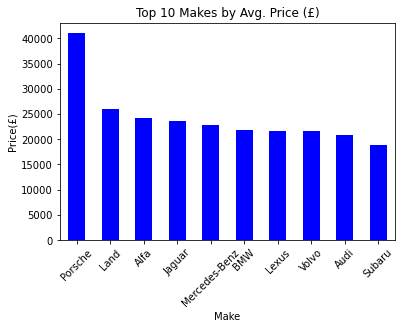

In [240]:
# Bar chart top 10 makes in stock
barchart = top_10_brands_by_average_price.plot.bar(x="Brands", y="Price (£)", ylabel="Price(£)", cmap="winter", title="Top 10 Makes by Avg. Price (£)")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Smart'),
  Text(1, 0, 'Fiat'),
  Text(2, 0, 'Ssangyong'),
  Text(3, 0, 'Dacia'),
  Text(4, 0, 'Renault'),
  Text(5, 0, 'Vauxhall'),
  Text(6, 0, 'Suzuki'),
  Text(7, 0, 'Citroen'),
  Text(8, 0, 'Infiniti'),
  Text(9, 0, 'DS')])

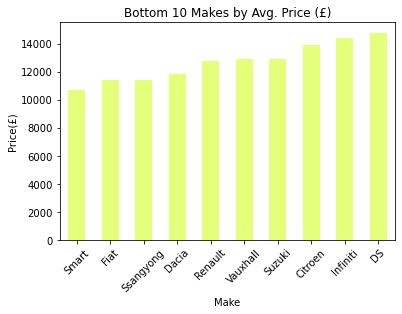

In [241]:
# Bottom 10 makes in stock by average price
bottom_10_brands_by_average_price = brand_averages.sort_values(ascending=True).head(10)

# Bar chart bottom 10 makes in stock
barchart = bottom_10_brands_by_average_price.plot.bar(x="Make", y="Average Price (£)", ylabel="Price(£)", cmap="Wistia", title="Bottom 10 Makes by Avg. Price (£)")
plt.xticks(rotation=45)

In [242]:
# Top 10 models in stock by average price
model_averages = vehicle_df.groupby('Model')['Price (£)'].mean()
top_10_models_by_average_price = model_averages.sort_values(ascending=False).head(10)
top_10_models_by_average_price

Model
Rover Range Rover          52200.000000
Land Cruiser               45050.000000
Rover Discovery            43125.000000
Rover Range Rover Sport    42885.714286
Macan                      42385.714286
718 Cayman                 41900.000000
GLE Class                  38600.000000
S Class                    38366.666667
X5                         37050.000000
Rover Range Rover Velar    34533.333333
Name: Price (£), dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Rover Range Rover'),
  Text(1, 0, 'Land Cruiser'),
  Text(2, 0, 'Rover Discovery'),
  Text(3, 0, 'Rover Range Rover Sport'),
  Text(4, 0, 'Macan'),
  Text(5, 0, '718 Cayman'),
  Text(6, 0, 'GLE Class'),
  Text(7, 0, 'S Class'),
  Text(8, 0, 'X5'),
  Text(9, 0, 'Rover Range Rover Velar')])

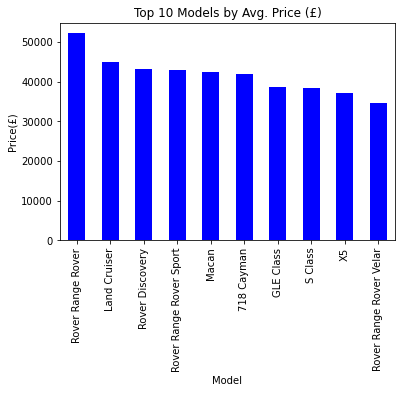

In [243]:
# Bar chart top 10 models in stock
barchart = top_10_models_by_average_price.plot.bar(x="Models", y="Price (£)", ylabel="Price(£)", cmap="winter", title="Top 10 Models by Avg. Price (£)")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Ka'),
  Text(1, 0, 'Celerio'),
  Text(2, 0, 'Viva'),
  Text(3, 0, 'Baleno'),
  Text(4, 0, 'Soul'),
  Text(5, 0, 'Citigo'),
  Text(6, 0, 'C3 Picasso'),
  Text(7, 0, 'Meriva'),
  Text(8, 0, 'Scenic'),
  Text(9, 0, 'ADAM')])

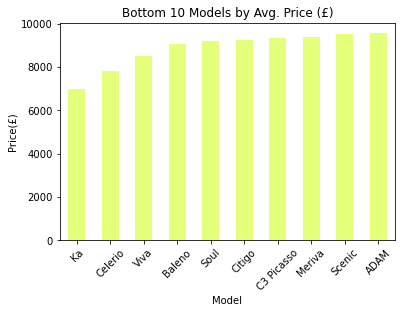

In [244]:
# Bottom 10 models in stock by average price
bottom_10_models_by_average_price = model_averages.sort_values(ascending=True).head(10)

# Bar chart bottom 10 makes in stock
barchart = bottom_10_models_by_average_price.plot.bar(x="Make", y="Average Price (£)", ylabel="Price(£)", cmap="Wistia", title="Bottom 10 Models by Avg. Price (£)")
plt.xticks(rotation=45)

In [245]:
# Relationship between registration year and resale price
year_averages = vehicle_df.groupby('Registration Year')['Price (£)'].mean().sort_index(ascending=False)
year_averages_df = round(pd.DataFrame(year_averages),2)
year_averages_df

,Price (£)
Registration Year,
2022,19502.05
2021,18724.74
2020,18105.22
2019,18171.02
2018,17580.59
2017,16486.78
2016,14045.64
2015,13163.49
2014,10880.00


(array([2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,
        2022., 2023.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

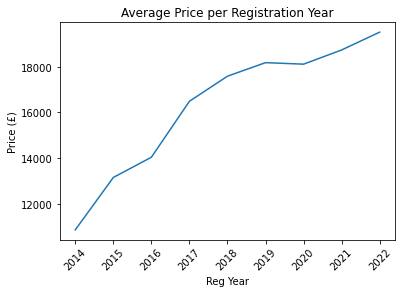

In [246]:
# Line graph - Registration year vs price
registration_years = year_averages_df.index.tolist()
prices_per_year = year_averages_df.iloc[:,0].tolist()

plt.plot(registration_years, prices_per_year, label="Price (£)")
plt.title("Average Price per Registration Year")
plt.xlabel("Reg Year")
plt.ylabel("Price (£)")
plt.xticks(rotation=45)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

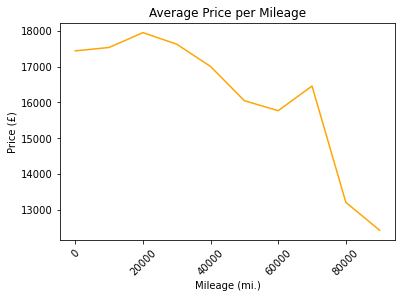

In [247]:
# Relationship between mileage and resale price
vehicle_df['Mileage Category'] = vehicle_df['Milage'] // 10000 * 10000
mileage_averages_df = vehicle_df.groupby('Mileage Category')['Price (£)'].mean().sort_index(ascending=False)
mileage_averages_df = round(pd.DataFrame(mileage_averages_df),2)

# Line Graph
mileage_categories = mileage_averages_df.index.tolist()
prices_per_mileage_cat = mileage_averages_df.iloc[:,0].tolist()

plt.plot(mileage_categories, prices_per_mileage_cat, label="Price (£)", color='orange')
plt.title("Average Price per Mileage")
plt.xlabel("Mileage (mi.)")
plt.ylabel("Price (£)")
plt.xticks(rotation=45)

([<matplotlib.patches.Wedge at 0x7fb168825550>,
 [Text(-0.17174608698486798, 1.0865096785603827, 'Alternative'),
  Text(-1.0218990887007502, 0.40708998085506376, 'Diesel'),
  Text(1.0147684394461705, -0.4245527226434712, 'Petrol')],
 [Text(-0.09367968380992799, 0.5926416428511178, '0.5%'),
  Text(-0.5573995029276819, 0.2220490804663984, '32.4%'),
  Text(0.5535100578797293, -0.23157421235098424, '67.1%')])

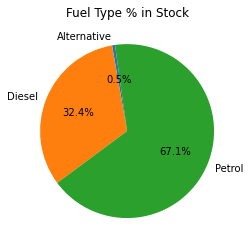

In [248]:
# Get number of cars in stock for each fuel type
fuel_count = vehicle_df['Fuel Type'].value_counts()

# Group alternative fuels (to avoid overlapping in pie chart as value are too small)
fuel_types = list(fuel_count.index)
fuel_type_count = []

for fuel_type in fuel_types:
    fuel_type_count.append(fuel_count[fuel_type])

fuel_type_dict_count = {'Fuel Type': fuel_types, 'Count': fuel_type_count}
fuel_type_dict_count

fuel_type_df = pd.DataFrame(fuel_type_dict_count)

fuel_type_df['Fuel Type'] = fuel_type_df['Fuel Type'].replace(['Hybrid', 'Petrol & LPG', 'Electric', 'Plug-in hybrid'], 'Alternative')
fuel_type_df = fuel_type_df.groupby('Fuel Type').sum()

# Fuel type pie chart
fuel_type_count = fuel_type_df['Count']
plt.title("Fuel Type % in Stock")
plt.pie(fuel_type_count, labels=fuel_type_count.index, autopct='%1.1f%%', startangle=98)

In [249]:
# Fuel type count
fuel_count.sort_values(ascending=False)

Petrol            4177
Diesel            2018
Hybrid              28
Electric             3
Petrol & LPG         2
Plug-in hybrid       1
Name: Fuel Type, dtype: int64

<AxesSubplot:title={'center':'Fuel Type by Avg. Price (£)'}, xlabel='Fuel Type', ylabel='Price (£)'>

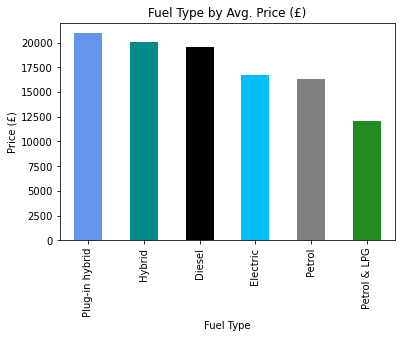

In [250]:
# Average price by fuel type
fuel_type_average = vehicle_df.groupby('Fuel Type')['Price (£)'].mean().sort_values(ascending=False)
fuel_type_average = round(fuel_type_average, 2)
fuel_type_average.index
colours = {'Hybrid': 'darkcyan', 'Diesel':'black', 'Petrol':'grey', 'Petrol & LPG':'forestgreen', 'Electric':'deepskyblue', 'Plug-in hybrid': 'cornflowerblue'}
fuel_type_average.plot.bar(x="Fuel Type", y="Price", ylabel="Price (£)", color=[colours[key] for key in fuel_type_average.index], title="Fuel Type by Avg. Price (£)")

In [251]:
# Question 1: Which models retain their value the most?
# Get data frame with average value (£) by model by registration year
depreciation_table = vehicle_df.pivot_table(index=["Model"], columns=["Registration Year"], values="Price (£)", aggfunc="mean")
depreciation_table = depreciation_table.round(2)
depreciation_df = depreciation_table.reset_index()
depreciation_df = depreciation_df.drop(columns=[2014,2022]).dropna()
depreciation_df

Registration Year,Model,2015,2016,2017,2018,2019,2020,2021
0,1 Series,13560.00,16450.00,18525.00,20500.00,20989.13,23919.57,32100.00
3,2 Series,19850.00,19131.82,20283.33,19725.00,21663.33,20550.00,21100.00
9,3 Series,17000.00,17987.50,23770.00,19633.33,25240.00,29083.33,30500.00
11,3008,9200.00,10650.00,17333.33,18050.00,19394.74,22050.00,22050.00
19,500,8733.33,9283.33,10037.50,9595.83,10417.11,11975.00,11956.25
29,A Class,13950.00,14850.00,17652.94,20403.79,22084.95,24110.00,22733.33
30,A1,12900.00,14512.50,13106.67,13990.91,19705.17,21750.00,20635.71
31,A3,14600.00,15514.29,16920.83,17655.88,20308.33,22177.27,24125.00
57,C Class,16175.00,18975.00,20450.00,22092.19,23711.90,22150.00,30250.00
90,Corsa,10883.33,10470.83,10130.00,10571.74,10726.83,14020.83,14468.42


<AxesSubplot:title={'center':'Average Depreciation % by Model'}, xlabel='Model', ylabel='% Depreciation'>

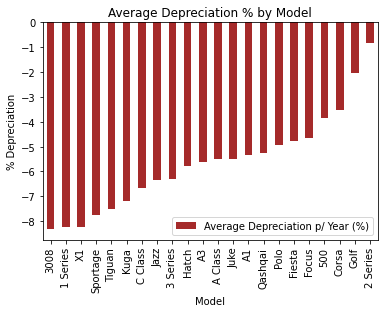

In [252]:
# Models in stock showing the most depreciation
depreciation_df['Average Depreciation p/ Year (%)'] = round((((depreciation_df[2015] - depreciation_df[2021]) / 7) / depreciation_df[2021]) * 100, 2)
depreciation_df = depreciation_df.sort_values('Average Depreciation p/ Year (%)', ascending=True)
depreciation_df

# Bar chart
depreciation_df.plot.bar(x="Model", y="Average Depreciation p/ Year (%)", ylabel="% Depreciation", color="brown", title="Average Depreciation % by Model")

<AxesSubplot:title={'center':'Average Depreciation % by Make'}, xlabel='Make', ylabel='% Depreciation'>

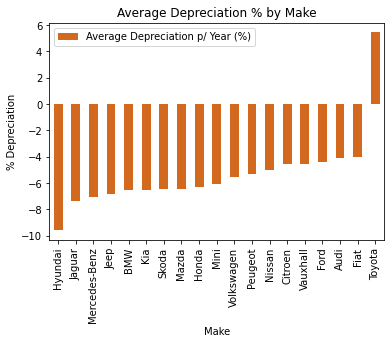

In [253]:
# And by make?
depreciation_table = vehicle_df.pivot_table(index=["Make"], columns=["Registration Year"], values="Price (£)", aggfunc="mean")
depreciation_table = depreciation_table.round(2)
depreciation_df = depreciation_table.reset_index()
depreciation_df = depreciation_df.drop(columns=[2014,2022]).dropna()

depreciation_df['Average Depreciation p/ Year (%)'] = round((((depreciation_df[2015] - depreciation_df[2021]) / 7) / depreciation_df[2021]) * 100, 2)
depreciation_df = depreciation_df.sort_values('Average Depreciation p/ Year (%)', ascending=True)

depreciation_df.plot.bar(x="Make", y="Average Depreciation p/ Year (%)", ylabel="% Depreciation", color="chocolate", title="Average Depreciation % by Make")

<AxesSubplot:title={'center':'Average Depreciation % by Mileage'}, xlabel='Mileage Category', ylabel='% Depreciation'>

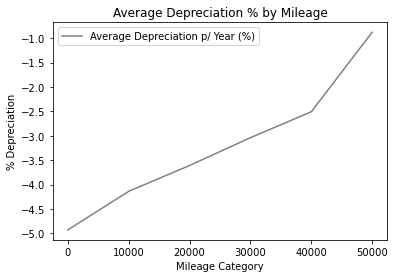

In [254]:
# How does mileage affect depreciation?
depreciation_table = vehicle_df.pivot_table(index=["Mileage Category"], columns=["Registration Year"], values="Price (£)", aggfunc="mean")
depreciation_table = depreciation_table.round(2)
depreciation_df = depreciation_table.reset_index()
depreciation_df = depreciation_df.drop(columns=[2014,2022]).dropna()

depreciation_df['Average Depreciation p/ Year (%)'] = round((((depreciation_df[2015] - depreciation_df[2021]) / 7) / depreciation_df[2021]) * 100, 2)
depreciation_df = depreciation_df.sort_values('Average Depreciation p/ Year (%)', ascending=True)

depreciation_df.plot.line(x="Mileage Category", y="Average Depreciation p/ Year (%)", ylabel="% Depreciation", color="grey", title="Average Depreciation % by Mileage")

<AxesSubplot:title={'center':'Average Depreciation % by Fuel Type'}, xlabel='Fuel Type', ylabel='Depreciation %'>

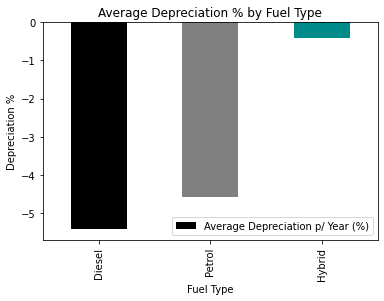

In [255]:
# Finally, what is the depreciation rates by fuel types?
depreciation_table = vehicle_df.pivot_table(index=["Fuel Type"], columns=["Registration Year"], values="Price (£)", aggfunc="mean")
depreciation_table = depreciation_table.round(2)
depreciation_df = depreciation_table.reset_index()
depreciation_df = depreciation_df.drop(columns=[2014,2022]).dropna()

depreciation_df['Average Depreciation p/ Year (%)'] = round((((depreciation_df[2015] - depreciation_df[2021]) / 7) / depreciation_df[2021]) * 100, 2)
depreciation_df = depreciation_df.sort_values('Average Depreciation p/ Year (%)', ascending=True)
depreciation_df.plot.bar(x="Fuel Type", y="Average Depreciation p/ Year (%)", ylabel="Depreciation %", color=['black', 'grey', 'darkcyan'], title="Average Depreciation % by Fuel Type")

In [262]:
# Question 2: How does the number of owners affect the price?
# First, how many owners each car goes through on average?
average_owners = round(vehicle_df['N of Owners'].mean(),1)
print("On average, each car goes through", average_owners, "owners")

On average, each car goes through 1.7 owners


<AxesSubplot:title={'center':'Relationship Between Number of Owners and Price'}, xlabel='N of Owners', ylabel='Price (£)'>

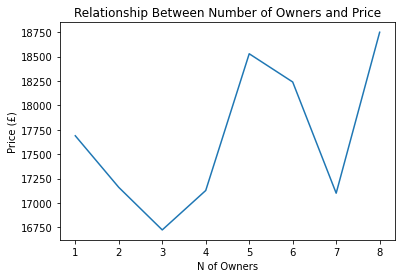

In [263]:
price_averages_by_owners = vehicle_df.groupby('N of Owners')['Price (£)'].mean()

# Line graph
price_averages_by_owners.plot.line(x='N of Owners', y='Price (£)', ylabel="Price (£)", title="Relationship Between Number of Owners and Price")

In [264]:
# How many miles does each owner drive on average?
vehicle_df['Miles p/ Owner'] = round(vehicle_df['Milage'] / vehicle_df['N of Owners'])
average_miles_per_owner = round(vehicle_df['Miles p/ Owner'].mean(),2)
print("On average, each owner drivers", average_miles_per_owner, "miles in each car")

On average, each owner drivers 19945.69 miles in each car


<AxesSubplot:title={'center':'Which Cars People Keep for Longer'}, xlabel='Model', ylabel='Average Number of Owners'>

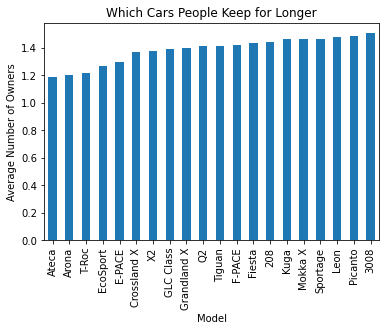

In [259]:
# Question 3: Which models do people keep for longer?
# Get models with significant occurences in the data (+25) and drop recent rows (2021 and later)
longevity_df = vehicle_df[vehicle_df["Registration Year"] < 2021]
model_count = longevity_df['Model'].value_counts()
model_selection = list(model_count[model_count >= 25].index)

# Group models by number of owners
models_by_owners = longevity_df.groupby('Model')['N of Owners'].mean()
models_by_owners = models_by_owners.loc[model_selection].sort_values(ascending=True)
models_by_owners = models_by_owners.head(20)

# Bar chart
models_by_owners.plot.bar(x="Model", y="N of Owners", ylabel="Average Number of Owners", title="Which Cars People Keep for Longer")

<AxesSubplot:title={'center':'Which Cars People Sell More Often'}, xlabel='Model', ylabel='Average Number of Owners'>

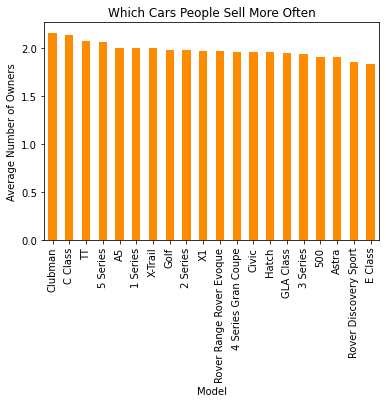

In [260]:
# Which cars are less desirable?
# Group models by number of owners
models_by_owners = longevity_df.groupby('Model')['N of Owners'].mean()
models_by_owners = models_by_owners.loc[model_selection].sort_values(ascending=False)
models_by_owners = models_by_owners.head(20)

# Bar chart
models_by_owners.plot.bar(x="Model", y="N of Owners", ylabel="Average Number of Owners", color="darkorange", title="Which Cars People Sell More Often")